In [1]:
import os
import pandas as pd
import torch
from tqdm import tqdm
import numpy as np

from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    ScaleIntensityd, NormalizeIntensityd, EnsureTyped,
    Compose, LoadImage, EnsureChannelFirst, Resize, ScaleIntensity, ToTensor
)

from monai.metrics import DiceMetric
from monai.bundle import ConfigParser
from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt
import seaborn as sns  # also required for sns.histplot

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
cohort_path = "../data/PI-CAI/cohort.csv"
file_data_root = "../data/PI-CAI/file_data"
bundle_dir = "../models/prostate_mri_anatomy"
model_weights = os.path.join(bundle_dir, "models", "model.pt")
config_path = os.path.join(bundle_dir, "configs", "inference.json")

In [4]:
# Load model from bundle
parser = ConfigParser()
parser.read_config(config_path)
parser["bundle_root"] = bundle_dir

# Load model and weights
network = parser.get_parsed_content("network_def").to(device)
weights = torch.load(model_weights, map_location=device)
network.load_state_dict(weights)
network.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.15, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.15, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, t

In [5]:
# Dice metric
dice_metric = DiceMetric(include_background=False, reduction="mean")
dice_scores = []

In [6]:
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, ResizeD, ScaleIntensityd,
    ToTensord, Compose
)


In [7]:
from monai.transforms import (
    LoadImage,
    EnsureChannelFirst,
    Resize,
    ScaleIntensity,
    ToTensor,
    Compose
)

# Manual preprocessing pipeline for a single image
preprocess = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize((96, 96, 96)),
    ScaleIntensity(),
    ToTensor()
])

# Preprocessing helper
def preprocess_image(path):
    return preprocess(path).unsqueeze(0)  # [1, C, D, H, W]


In [8]:
# Load cohort
df = pd.read_csv(cohort_path)

In [52]:
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
import torch
import pandas as pd
import os
from tqdm import tqdm

print("\n🔍 Evaluating pre-trained model on D2...")

df = pd.read_csv(cohort_path)
dice_metric = DiceMetric(include_background=False, reduction="mean")
dice_scores = []

# Optional: Store predictions/GTs for later visualization or analysis
all_preds = {}
all_gts = {}

for idx, row in tqdm(df.iterrows(), total=len(df)):
    patient_id = row["patientID"]
    print(f"\n🧪 Processing patient: {patient_id}")

    try:
        t2_path = os.path.join(file_data_root, row["T2W_NIFTI"])
        gland_path = os.path.join(file_data_root, row["Gland_NIFTI"])

        t2_tensor = preprocess_image(t2_path).to(device)
        gland_tensor = preprocess_image(gland_path).to(device)

        # Binarize GT
        gland_tensor[gland_tensor > 0] = 1.0

        with torch.no_grad():
            pred = sliding_window_inference(
                inputs=t2_tensor,
                roi_size=(96, 96, 96),
                sw_batch_size=1,
                predictor=network
            )

            # Channel 1 = Central Gland
            pred_bin = (pred[:, 1:2] > 0.5).float()

        # Sanity log
        print(f"Pred sum: {pred_bin.sum().item():.2f}, GT sum: {gland_tensor.sum().item():.2f}")

        dice_metric.reset()
        dice_metric(y_pred=pred_bin, y=gland_tensor)
        score = dice_metric.aggregate().item()
        dice_scores.append((patient_id, score))
        print(f"✅ Dice Score: {score:.4f}")

        # Store for analysis
        all_preds[patient_id] = pred_bin.cpu()
        all_gts[patient_id] = gland_tensor.cpu()

    except Exception as e:
        print(f"❌ Error processing patient {patient_id}: {e}")

# Save scores as DataFrame
results_df = pd.DataFrame(dice_scores, columns=["patientID", "dice"])



🔍 Evaluating pre-trained model on D2...


  0%|          | 0/80 [00:00<?, ?it/s]


🧪 Processing patient: 11284


  1%|▏         | 1/80 [00:00<01:00,  1.31it/s]

Pred sum: 660262.00, GT sum: 884730.00
✅ Dice Score: 0.8547

🧪 Processing patient: 10372


  2%|▎         | 2/80 [00:01<00:56,  1.39it/s]

Pred sum: 664327.00, GT sum: 884733.00
✅ Dice Score: 0.8577

🧪 Processing patient: 10768


  4%|▍         | 3/80 [00:02<00:55,  1.39it/s]

Pred sum: 683839.00, GT sum: 884733.00
✅ Dice Score: 0.8719

🧪 Processing patient: 10074


  5%|▌         | 4/80 [00:02<00:51,  1.46it/s]

Pred sum: 701718.00, GT sum: 884733.00
✅ Dice Score: 0.8846

🧪 Processing patient: 10418


  6%|▋         | 5/80 [00:03<00:50,  1.48it/s]

Pred sum: 654565.00, GT sum: 884730.00
✅ Dice Score: 0.8505

🧪 Processing patient: 11165


  8%|▊         | 6/80 [00:04<00:50,  1.45it/s]

Pred sum: 674442.00, GT sum: 884730.00
✅ Dice Score: 0.8651

🧪 Processing patient: 10442


  9%|▉         | 7/80 [00:04<00:49,  1.49it/s]

Pred sum: 734200.00, GT sum: 884733.00
✅ Dice Score: 0.9070

🧪 Processing patient: 10486


 10%|█         | 8/80 [00:05<00:47,  1.51it/s]

Pred sum: 721072.00, GT sum: 884733.00
✅ Dice Score: 0.8981

🧪 Processing patient: 10043


 11%|█▏        | 9/80 [00:06<00:46,  1.52it/s]

Pred sum: 645985.00, GT sum: 884730.00
✅ Dice Score: 0.8440

🧪 Processing patient: 10164


 12%|█▎        | 10/80 [00:06<00:48,  1.44it/s]

Pred sum: 716551.00, GT sum: 884733.00
✅ Dice Score: 0.8950

🧪 Processing patient: 10241


 14%|█▍        | 11/80 [00:07<00:49,  1.39it/s]

Pred sum: 671722.00, GT sum: 884730.00
✅ Dice Score: 0.8631

🧪 Processing patient: 10522


 15%|█▌        | 12/80 [00:08<00:48,  1.40it/s]

Pred sum: 735394.00, GT sum: 884733.00
✅ Dice Score: 0.9078

🧪 Processing patient: 10728


 16%|█▋        | 13/80 [00:09<00:50,  1.33it/s]

Pred sum: 709290.00, GT sum: 884733.00
✅ Dice Score: 0.8899

🧪 Processing patient: 10825


 18%|█▊        | 14/80 [00:09<00:48,  1.35it/s]

Pred sum: 693619.00, GT sum: 884733.00
✅ Dice Score: 0.8789

🧪 Processing patient: 11137


 19%|█▉        | 15/80 [00:10<00:47,  1.37it/s]

Pred sum: 699427.00, GT sum: 884733.00
✅ Dice Score: 0.8830

🧪 Processing patient: 11236


 20%|██        | 16/80 [00:11<00:44,  1.42it/s]

Pred sum: 728438.00, GT sum: 884733.00
✅ Dice Score: 0.9031

🧪 Processing patient: 11361


 21%|██▏       | 17/80 [00:11<00:43,  1.43it/s]

Pred sum: 645629.00, GT sum: 884733.00
✅ Dice Score: 0.8438

🧪 Processing patient: 10107


 22%|██▎       | 18/80 [00:12<00:42,  1.45it/s]

Pred sum: 603244.00, GT sum: 884730.00
✅ Dice Score: 0.8108

🧪 Processing patient: 10539


 24%|██▍       | 19/80 [00:13<00:41,  1.47it/s]

Pred sum: 671332.00, GT sum: 884733.00
✅ Dice Score: 0.8629

🧪 Processing patient: 10743


 25%|██▌       | 20/80 [00:13<00:40,  1.50it/s]

Pred sum: 718962.00, GT sum: 884733.00
✅ Dice Score: 0.8966

🧪 Processing patient: 10910


 26%|██▋       | 21/80 [00:14<00:40,  1.46it/s]

Pred sum: 685688.00, GT sum: 884733.00
✅ Dice Score: 0.8732

🧪 Processing patient: 11051


 28%|██▊       | 22/80 [00:15<00:38,  1.49it/s]

Pred sum: 659695.00, GT sum: 884730.00
✅ Dice Score: 0.8543

🧪 Processing patient: 11086


 29%|██▉       | 23/80 [00:15<00:38,  1.48it/s]

Pred sum: 620639.00, GT sum: 884733.00
✅ Dice Score: 0.8246

🧪 Processing patient: 11155


 30%|███       | 24/80 [00:16<00:39,  1.41it/s]

Pred sum: 640128.00, GT sum: 884730.00
✅ Dice Score: 0.8396

🧪 Processing patient: 11444


 31%|███▏      | 25/80 [00:17<00:45,  1.22it/s]

Pred sum: 660981.00, GT sum: 884730.00
✅ Dice Score: 0.8552

🧪 Processing patient: 10005


 32%|███▎      | 26/80 [00:18<00:45,  1.19it/s]

Pred sum: 705330.00, GT sum: 884730.00
✅ Dice Score: 0.8872

🧪 Processing patient: 10329


 34%|███▍      | 27/80 [00:19<00:46,  1.15it/s]

Pred sum: 664597.00, GT sum: 884733.00
✅ Dice Score: 0.8579

🧪 Processing patient: 10434


 35%|███▌      | 28/80 [00:20<00:45,  1.13it/s]

Pred sum: 659330.00, GT sum: 884730.00
✅ Dice Score: 0.8540

🧪 Processing patient: 10484


 36%|███▋      | 29/80 [00:21<00:43,  1.17it/s]

Pred sum: 619558.00, GT sum: 884733.00
✅ Dice Score: 0.8237

🧪 Processing patient: 10807


 38%|███▊      | 30/80 [00:22<00:40,  1.23it/s]

Pred sum: 706661.00, GT sum: 884733.00
✅ Dice Score: 0.8881

🧪 Processing patient: 10888


 39%|███▉      | 31/80 [00:22<00:37,  1.32it/s]

Pred sum: 698109.00, GT sum: 884733.00
✅ Dice Score: 0.8821

🧪 Processing patient: 11177


 40%|████      | 32/80 [00:23<00:35,  1.36it/s]

Pred sum: 750001.00, GT sum: 884733.00
✅ Dice Score: 0.9176

🧪 Processing patient: 11253


 41%|████▏     | 33/80 [00:24<00:34,  1.35it/s]

Pred sum: 661378.00, GT sum: 884730.00
✅ Dice Score: 0.8555

🧪 Processing patient: 11300


 42%|████▎     | 34/80 [00:24<00:33,  1.37it/s]

Pred sum: 676792.00, GT sum: 884730.00
✅ Dice Score: 0.8668

🧪 Processing patient: 10085


 44%|████▍     | 35/80 [00:25<00:31,  1.42it/s]

Pred sum: 642133.00, GT sum: 884733.00
✅ Dice Score: 0.8411

🧪 Processing patient: 10274


 45%|████▌     | 36/80 [00:26<00:31,  1.41it/s]

Pred sum: 720575.00, GT sum: 884733.00
✅ Dice Score: 0.8977

🧪 Processing patient: 10380


 46%|████▋     | 37/80 [00:27<00:31,  1.35it/s]

Pred sum: 690286.00, GT sum: 884730.00
✅ Dice Score: 0.8765

🧪 Processing patient: 10390


 48%|████▊     | 38/80 [00:27<00:30,  1.40it/s]

Pred sum: 747631.00, GT sum: 884733.00
✅ Dice Score: 0.9160

🧪 Processing patient: 10665


 49%|████▉     | 39/80 [00:28<00:28,  1.44it/s]

Pred sum: 699782.00, GT sum: 884733.00
✅ Dice Score: 0.8833

🧪 Processing patient: 10872


 50%|█████     | 40/80 [00:28<00:27,  1.47it/s]

Pred sum: 669169.00, GT sum: 884733.00
✅ Dice Score: 0.8613

🧪 Processing patient: 11168


 51%|█████▏    | 41/80 [00:29<00:27,  1.44it/s]

Pred sum: 697349.00, GT sum: 884730.00
✅ Dice Score: 0.8816

🧪 Processing patient: 10059


 52%|█████▎    | 42/80 [00:30<00:26,  1.44it/s]

Pred sum: 643019.00, GT sum: 884730.00
✅ Dice Score: 0.8418

🧪 Processing patient: 10262


 54%|█████▍    | 43/80 [00:31<00:27,  1.34it/s]

Pred sum: 581964.00, GT sum: 884730.00
✅ Dice Score: 0.7936

🧪 Processing patient: 10322


 55%|█████▌    | 44/80 [00:31<00:26,  1.35it/s]

Pred sum: 623204.00, GT sum: 884730.00
✅ Dice Score: 0.8266

🧪 Processing patient: 10340


 56%|█████▋    | 45/80 [00:32<00:24,  1.41it/s]

Pred sum: 593914.00, GT sum: 884733.00
✅ Dice Score: 0.8033

🧪 Processing patient: 10607


 57%|█████▊    | 46/80 [00:33<00:23,  1.43it/s]

Pred sum: 695585.00, GT sum: 884730.00
✅ Dice Score: 0.8803

🧪 Processing patient: 10798


 59%|█████▉    | 47/80 [00:34<00:23,  1.41it/s]

Pred sum: 673170.00, GT sum: 884733.00
✅ Dice Score: 0.8642

🧪 Processing patient: 10839


 60%|██████    | 48/80 [00:34<00:23,  1.36it/s]

Pred sum: 676511.00, GT sum: 884730.00
✅ Dice Score: 0.8666

🧪 Processing patient: 10915


 61%|██████▏   | 49/80 [00:35<00:22,  1.40it/s]

Pred sum: 615584.00, GT sum: 884733.00
✅ Dice Score: 0.8206

🧪 Processing patient: 11231


 62%|██████▎   | 50/80 [00:36<00:21,  1.40it/s]

Pred sum: 635882.00, GT sum: 884730.00
✅ Dice Score: 0.8363

🧪 Processing patient: 11278


 64%|██████▍   | 51/80 [00:36<00:19,  1.46it/s]

Pred sum: 722909.00, GT sum: 884730.00
✅ Dice Score: 0.8993

🧪 Processing patient: 10040


 65%|██████▌   | 52/80 [00:37<00:19,  1.44it/s]

Pred sum: 661312.00, GT sum: 884730.00
✅ Dice Score: 0.8555

🧪 Processing patient: 10117


 66%|██████▋   | 53/80 [00:38<00:18,  1.45it/s]

Pred sum: 708130.00, GT sum: 884733.00
✅ Dice Score: 0.8891

🧪 Processing patient: 10168


 68%|██████▊   | 54/80 [00:38<00:18,  1.43it/s]

Pred sum: 759030.00, GT sum: 884730.00
✅ Dice Score: 0.9235

🧪 Processing patient: 10211


 69%|██████▉   | 55/80 [00:39<00:17,  1.42it/s]

Pred sum: 618442.00, GT sum: 884730.00
✅ Dice Score: 0.8228

🧪 Processing patient: 10216


 70%|███████   | 56/80 [00:40<00:16,  1.44it/s]

Pred sum: 626033.00, GT sum: 884733.00
✅ Dice Score: 0.8288

🧪 Processing patient: 10339


 71%|███████▏  | 57/80 [00:40<00:15,  1.46it/s]

Pred sum: 662542.00, GT sum: 884733.00
✅ Dice Score: 0.8564

🧪 Processing patient: 10568


 72%|███████▎  | 58/80 [00:41<00:14,  1.48it/s]

Pred sum: 672045.00, GT sum: 884730.00
✅ Dice Score: 0.8634

🧪 Processing patient: 10668


 74%|███████▍  | 59/80 [00:42<00:13,  1.51it/s]

Pred sum: 749604.00, GT sum: 884733.00
✅ Dice Score: 0.9173

🧪 Processing patient: 10699


 75%|███████▌  | 60/80 [00:42<00:13,  1.47it/s]

Pred sum: 608272.00, GT sum: 884730.00
✅ Dice Score: 0.8148

🧪 Processing patient: 11122


 76%|███████▋  | 61/80 [00:43<00:12,  1.50it/s]

Pred sum: 659846.00, GT sum: 884730.00
✅ Dice Score: 0.8544

🧪 Processing patient: 11188


 78%|███████▊  | 62/80 [00:44<00:11,  1.53it/s]

Pred sum: 736823.00, GT sum: 884733.00
✅ Dice Score: 0.9088

🧪 Processing patient: 11247


 79%|███████▉  | 63/80 [00:44<00:11,  1.54it/s]

Pred sum: 618891.00, GT sum: 884730.00
✅ Dice Score: 0.8232

🧪 Processing patient: 11260


 80%|████████  | 64/80 [00:45<00:10,  1.56it/s]

Pred sum: 693842.00, GT sum: 884733.00
✅ Dice Score: 0.8791

🧪 Processing patient: 11280


 81%|████████▏ | 65/80 [00:46<00:09,  1.57it/s]

Pred sum: 708867.00, GT sum: 884733.00
✅ Dice Score: 0.8896

🧪 Processing patient: 10048


 82%|████████▎ | 66/80 [00:46<00:09,  1.51it/s]

Pred sum: 607650.00, GT sum: 884730.00
✅ Dice Score: 0.8143

🧪 Processing patient: 10097


 84%|████████▍ | 67/80 [00:47<00:08,  1.47it/s]

Pred sum: 683898.00, GT sum: 884733.00
✅ Dice Score: 0.8720

🧪 Processing patient: 10233


 85%|████████▌ | 68/80 [00:48<00:08,  1.49it/s]

Pred sum: 717788.00, GT sum: 884733.00
✅ Dice Score: 0.8958

🧪 Processing patient: 10268


 86%|████████▋ | 69/80 [00:48<00:07,  1.47it/s]

Pred sum: 665402.00, GT sum: 884733.00
✅ Dice Score: 0.8585

🧪 Processing patient: 10294


 88%|████████▊ | 70/80 [00:49<00:06,  1.48it/s]

Pred sum: 700812.00, GT sum: 884733.00
✅ Dice Score: 0.8840

🧪 Processing patient: 10503


 89%|████████▉ | 71/80 [00:50<00:06,  1.49it/s]

Pred sum: 656356.00, GT sum: 884730.00
✅ Dice Score: 0.8518

🧪 Processing patient: 10589


 90%|█████████ | 72/80 [00:50<00:05,  1.49it/s]

Pred sum: 670462.00, GT sum: 884730.00
✅ Dice Score: 0.8622

🧪 Processing patient: 10804


 91%|█████████▏| 73/80 [00:51<00:04,  1.46it/s]

Pred sum: 626052.00, GT sum: 884730.00
✅ Dice Score: 0.8288

🧪 Processing patient: 10968


 92%|█████████▎| 74/80 [00:52<00:04,  1.48it/s]

Pred sum: 663311.00, GT sum: 884733.00
✅ Dice Score: 0.8570

🧪 Processing patient: 11229


 94%|█████████▍| 75/80 [00:53<00:03,  1.43it/s]

Pred sum: 591833.00, GT sum: 884730.00
✅ Dice Score: 0.8016

🧪 Processing patient: 11384


 95%|█████████▌| 76/80 [00:53<00:02,  1.45it/s]

Pred sum: 697658.00, GT sum: 884733.00
✅ Dice Score: 0.8818

🧪 Processing patient: 10157


 96%|█████████▋| 77/80 [00:54<00:02,  1.43it/s]

Pred sum: 690759.00, GT sum: 884730.00
✅ Dice Score: 0.8769

🧪 Processing patient: 10383


 98%|█████████▊| 78/80 [00:55<00:01,  1.42it/s]

Pred sum: 682913.00, GT sum: 884730.00
✅ Dice Score: 0.8713

🧪 Processing patient: 11256


 99%|█████████▉| 79/80 [00:55<00:00,  1.42it/s]

Pred sum: 704223.00, GT sum: 884730.00
✅ Dice Score: 0.8864

🧪 Processing patient: 11448


100%|██████████| 80/80 [00:56<00:00,  1.42it/s]

Pred sum: 693283.00, GT sum: 884730.00
✅ Dice Score: 0.8787


In [53]:
# Save results
results_df = pd.DataFrame(dice_scores, columns=["patientID", "dice"])
results_df.to_csv("d2_eval_dice_scores.csv", index=False)
print("\n📊 Average Dice Score on D2:", results_df["dice"].mean())


📊 Average Dice Score on D2: 0.8648285791277885


In [54]:
print("\n📊 DICE SCORE ANALYSIS")
print(results_df["dice"].describe())  # mean, std, min, 25%, 50%, 75%, max


📊 DICE SCORE ANALYSIS
count    80.000000
mean      0.864829
std       0.029833
min       0.793564
25%       0.848857
50%       0.864659
75%       0.885074
max       0.923522
Name: dice, dtype: float64


In [55]:
print("Patients with Dice < 0.1:", (results_df["dice"] < 0.1).sum())
print("Patients with Dice < 0.2:", (results_df["dice"] < 0.2).sum())
print("Patients with Dice > 0.5:", (results_df["dice"] > 0.5).sum())

Patients with Dice < 0.1: 0
Patients with Dice < 0.2: 0
Patients with Dice > 0.5: 80


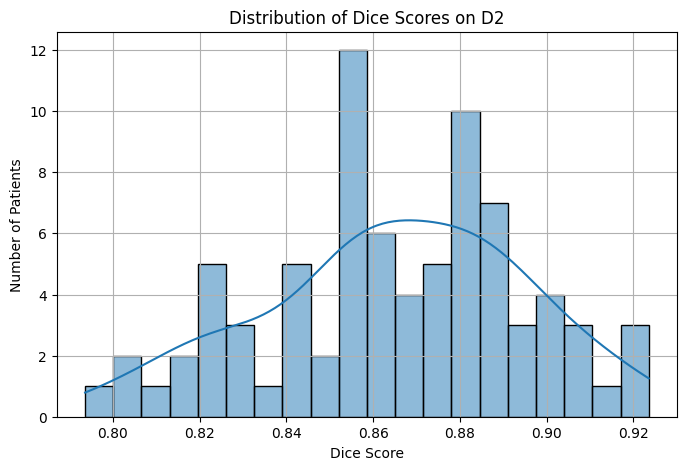

In [56]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["dice"].dropna(), bins=20, kde=True)
plt.title("Distribution of Dice Scores on D2")
plt.xlabel("Dice Score")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.show()


In [57]:
print("\n🔍 Worst performing patients:")
print(results_df.sort_values("dice").head(5))


🔍 Worst performing patients:
    patientID      dice
42      10262  0.793564
74      11229  0.801628
44      10340  0.803317
17      10107  0.810818
65      10048  0.814334


In [58]:
print("\n✅ Best performing patients:")
print(results_df.sort_values("dice", ascending=False).head(5))


✅ Best performing patients:
    patientID      dice
53      10168  0.923522
31      11177  0.917578
58      10668  0.917315
37      10390  0.916007
61      11188  0.908781


In [81]:
def visualize_prediction(patient_id):
    import matplotlib.pyplot as plt
    import numpy as np
    import os

    t2_path = os.path.join(file_data_root, f"{patient_id}/{patient_id}_t2w.nii.gz")
    gland_path = os.path.join(file_data_root, f"{patient_id}/{patient_id}_gland.nii.gz")

    t2_tensor = preprocess_image(t2_path).to(device)
    gland_tensor = preprocess_image(gland_path).to(device)

    # Binarize GT
    #gland_tensor[gland_tensor > 0] = 1.0

    with torch.no_grad():
        pred = sliding_window_inference(
            inputs=t2_tensor,
            roi_size=(96, 96, 96),
            sw_batch_size=1,
            predictor=network
        )

        # Channel 1 = Central Gland
        pred_bin = (pred[:, 1:2] > 0.5).float()

    # Convert to numpy and squeeze
    t2_np = t2_tensor.cpu().squeeze().numpy()        # [D, H, W]
    gland_np = gland_tensor.cpu().squeeze().numpy()  # [D, H, W]
    pred_np = pred_bin.cpu().squeeze().numpy()       # [D, H, W]

    # Binary GT for cleaner visual
    #gland_np = np.clip(gland_np, 0, 1)

    slice_idx = t2_np.shape[2] // 2  # Z-slice for axial view

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(t2_np[:, :, slice_idx], cmap="gray")
    plt.title("T2 Image")

    plt.subplot(1, 3, 2)
    plt.imshow(gland_np[:, :, slice_idx], cmap="Reds", vmin=0, vmax=1)
    plt.title(f"Patient {patient_id}\nGround Truth Gland")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_np[:, :, slice_idx], cmap="Blues", vmin=0, vmax=1)
    plt.title("Predicted Gland")

    plt.tight_layout()
    plt.show()


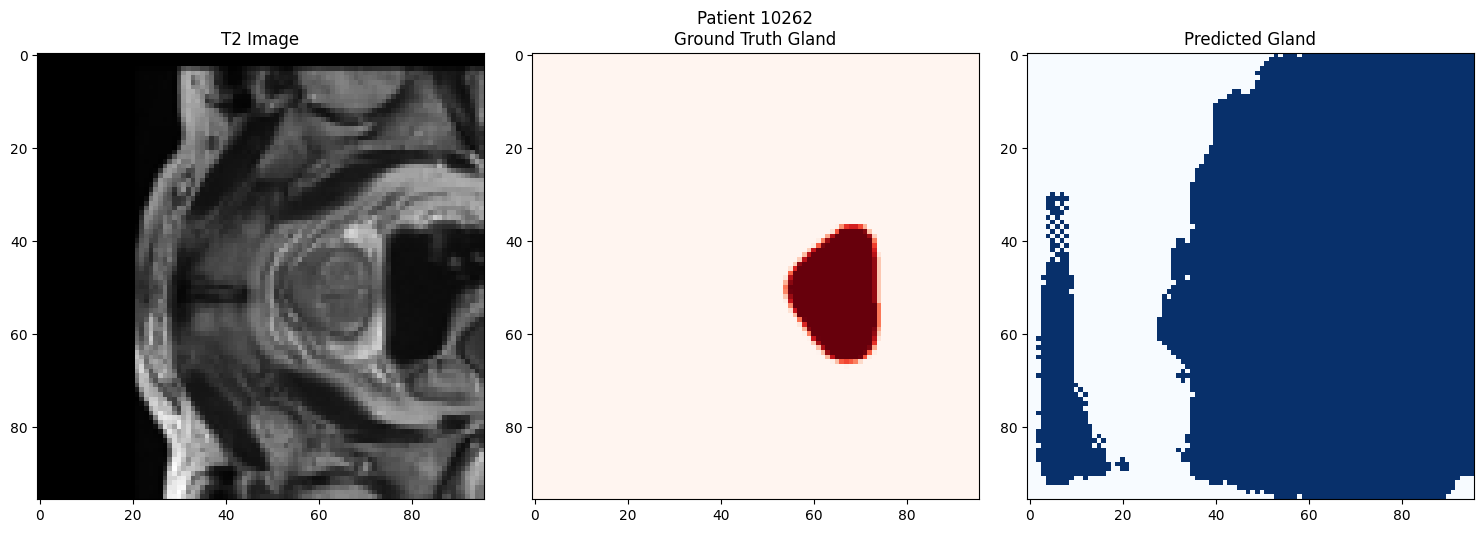

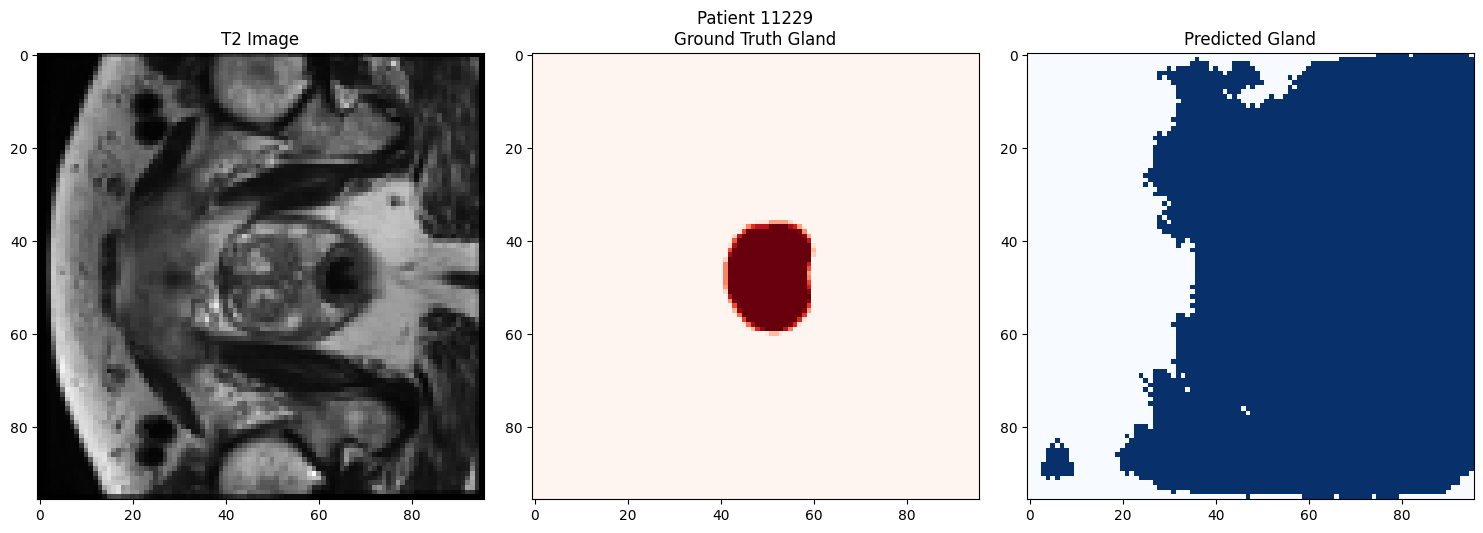

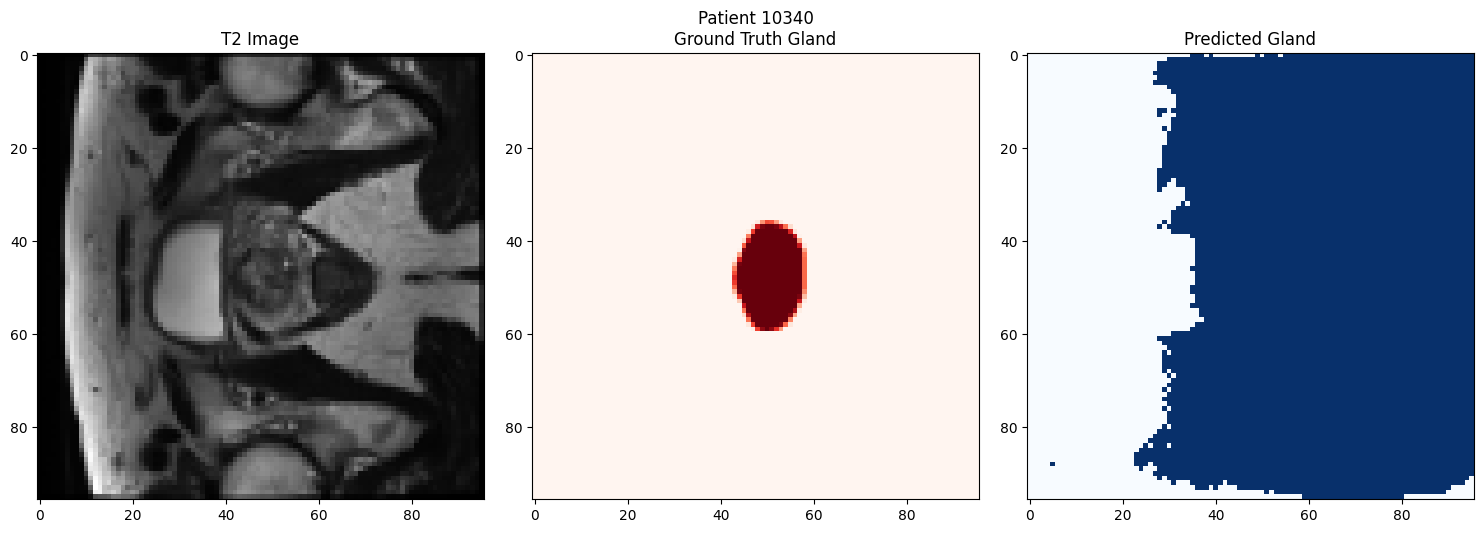

In [82]:
for pid in results_df.sort_values("dice").head(3)["patientID"]:
    visualize_prediction(pid)  # Worst 3

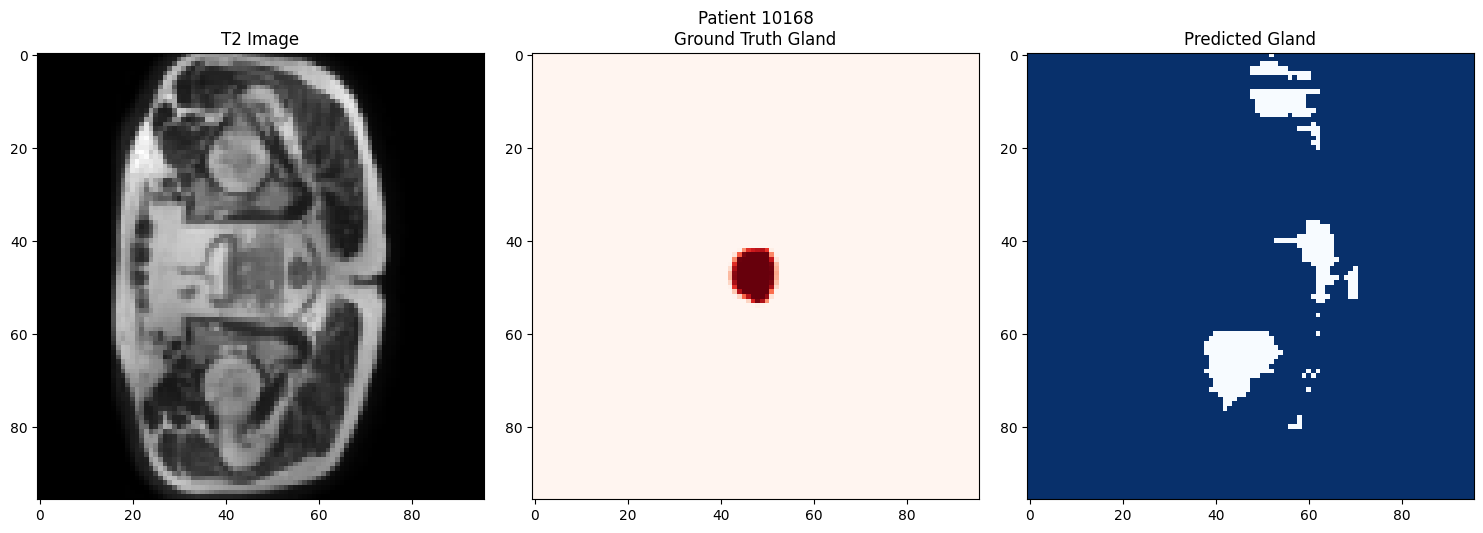

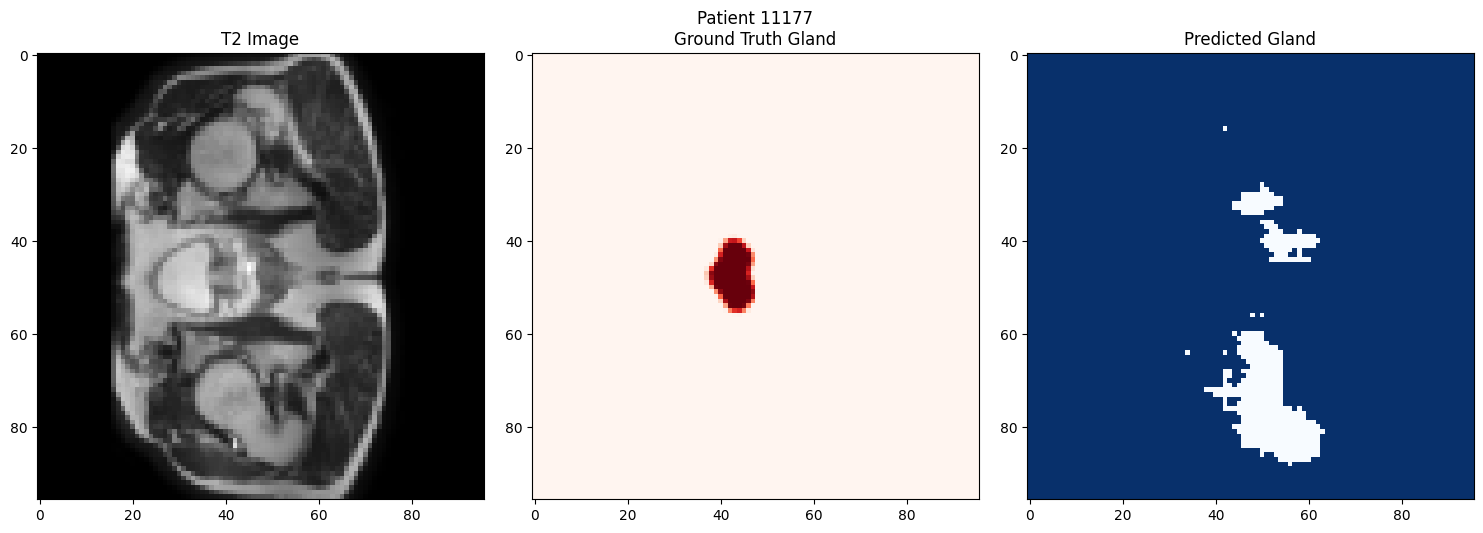

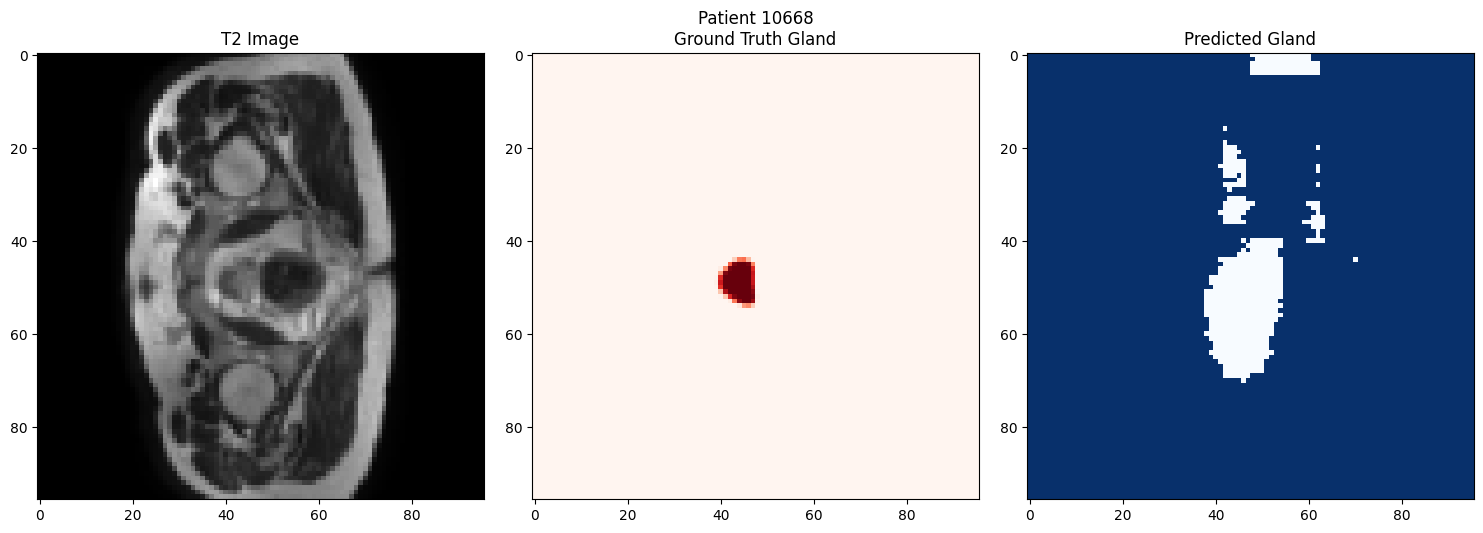

In [80]:
for pid in results_df.sort_values("dice", ascending=False).head(3)["patientID"]:
    visualize_prediction(pid)  # Best 3